In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import sys
sys.path.insert(0, "python")
from network import *
from protocols import *
from adversary import *
from simulator import *

/home/fberes/.conda/envs/ethsim/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Dandelion example

In [3]:
net = Network(400, 40, edge_weight="unweighted")

In [4]:
dp = DandelionProtocol(net, 0.1)

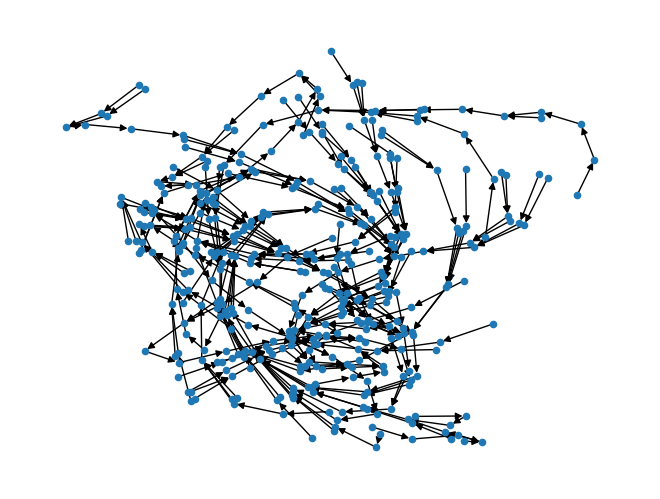

In [5]:
nx.draw(dp.line_graph, node_size=20)

In [6]:
adv = Adversary(net, 0.1)
sim = Simulator(dp, adv, 10, verbose=False)
sim.run(coverage_threshold=0.95)

In [7]:
%%time
evaluator = Evaluator(sim, "first_reach")
print(evaluator.get_report())

{'estimator': 'first_reach', 'hit_ratio': 0.1, 'inverse_rank': 0.1042879355304209, 'entropy': 1.1982929094215966, 'ndcg': 0.19195129523135396, 'message_spread_ratio': 0.6097499999999999}
CPU times: user 9.47 ms, sys: 5.37 ms, total: 14.8 ms
Wall time: 12.9 ms


In [8]:
%%time
evaluator = Evaluator(sim, "shortest_path")
print(evaluator.get_report())

{'estimator': 'shortest_path', 'hit_ratio': 0.0, 'inverse_rank': 0.019723229363486004, 'entropy': 5.881685840004413, 'ndcg': 0.13160777933575643, 'message_spread_ratio': 0.6097499999999999}
CPU times: user 172 ms, sys: 9.6 ms, total: 182 ms
Wall time: 179 ms


In [9]:
%%time
evaluator = Evaluator(sim, "dummy")
print(evaluator.get_report())

{'estimator': 'dummy', 'hit_ratio': 0.0, 'inverse_rank': 0.006612229453328328, 'entropy': 5.907176134581721, 'ndcg': 0.111176470133067, 'message_spread_ratio': 0.6097499999999999}
CPU times: user 51.7 ms, sys: 4.18 ms, total: 55.9 ms
Wall time: 51.6 ms


In [10]:
alma

NameError: name 'alma' is not defined

# Experiment example

In [ ]:
def run_and_eval(net: Network, adv: Adversary, protocol: Protocol):
    sim = Simulator(protocol, adv, int(network_size / 10), verbose=False)
    sim.run()
    evaluator = Evaluator(sim)
    report = evaluator.get_report()
    report["protocol"] = str(protocol)
    report["adversary_ratio"] = adv.ratio
    return report

In [ ]:
network_size = 1000
degree = 50
num_trials = 10
adversary_ratios = [0.01,0.025,0.05,0.075,0.1]
results = []

In [ ]:
%%time
# it could be parallelized
for adv_ratio in adversary_ratios:
    for _ in range(num_trials):
        # this part cannot be parallelized: it is important that different protocols will be evaluated with the same network and adversary setting
        net = Network(network_size, degree)
        adv = Adversary(net, adv_ratio)
        # BUT: messages won't be the same!!!
        results.append(run_and_eval(net, adv, BroadcastProtocol(net)))
        results.append(run_and_eval(net, adv, DandelionProtocol(net, 0.5)))
        results.append(run_and_eval(net, adv, DandelionProtocol(net, 0.25)))
    print(adv_ratio)

In [ ]:
import seaborn as sns

In [ ]:
results_df = pd.DataFrame(results)
results_df.head()

### Dummy adversary predicts message source for Dandelion much worse than in case of ismple broadcasting

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(15,15))
sns.boxplot(data=results_df, x="adversary_ratio", y="hit_ratio", hue="protocol", ax=ax[0][0])
sns.boxplot(data=results_df, x="adversary_ratio", y="inverse_rank", hue="protocol", ax=ax[0][1])
sns.boxplot(data=results_df, x="adversary_ratio", y="ndcg", hue="protocol", ax=ax[1][0])
sns.boxplot(data=results_df, x="adversary_ratio", y="entropy", hue="protocol", ax=ax[1][1])

### While the fraction of nodes reached by messages are the same range for all protocols

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(10,6))
sns.boxplot(data=results_df, x="adversary_ratio", y="message_spread_ratio", hue="protocol", ax=ax)